<a href="https://colab.research.google.com/github/Mathis1993/DCGAN/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/DCGAN/

/content/drive/My Drive/Colab Notebooks/DCGAN


## Choose Hardware Accelerator

From the menu, select
* Runtime -> Change Runtime Type -> Hardware Accelerator --> GPU


## DCGAN

In [3]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed) #set randoms' random seed
torch.manual_seed(manualSeed) #set pytorch's random seed

Random Seed:  999


In [0]:
# Root directory for dataset
dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [0]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #pixel values are already in the range [0,1]
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

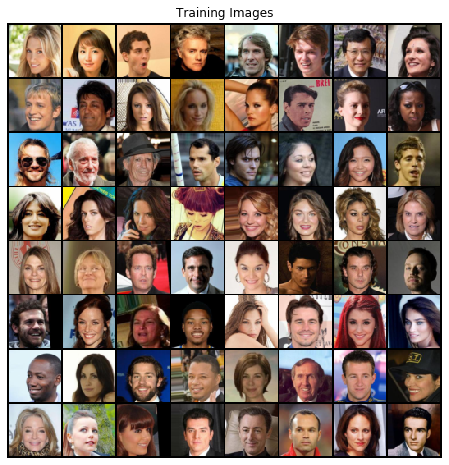

In [6]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")

#dataloader giving tuple of (data-tensor, target-tensor) with target-tensor defaulting to 0
#also have to transpose axes for plotting images from (3,64,64) to (64,64,3)
#make grid of the first 64 images
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True),(1,2,0))) #normalize from [-1,1] to [0,1] again

## Discriminator

In [44]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()
    
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False)
    self.batnorm1 = nn.BatchNorm2d(num_features=128)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False)
    self.batnorm2 = nn.BatchNorm2d(num_features=256)
    self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False)
    self.batnorm3 = nn.BatchNorm2d(num_features=512)
    self.conv5 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False)

    def forward(self, x):
      x = self.conv1(x)
      x = F.leaky_relu(x, slope=0.2)
      x = self.conv2(x)
      x = self.batnorm1(x)
      x = F.leaky_relu(x, slope=0.2)
      x = self.conv3(x)
      x = self.batnorm2(x)
      x = self.leaky_relu(x, slope=0.2)
      x = self.conv4(x)
      x = self.batnorm3(x)
      x = F.leaky_relu(x, slope=0.2)
      x = self.conv5(x)
      x = F.sigmoid(x)



torch.Size([64, 3, 64, 64])


torch.Size([64, 64, 3])

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [0]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()
    
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(negative_slope=0.2)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=128),
        nn.LeakyReLU(negative_slope=0.2)
    )

    self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=256),
        nn.LeakyReLU(negative_slope=0.2)
    )

    self.conv_block4 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=512),
        nn.LeakyReLU(negative_slope=0.2)
    )

    self.conv_block5 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.conv_block3(x)
    x = self.conv_block4(x)
    x = self.conv_block5(x)
    return x

## Generator

In [0]:
class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()
    
    self.convT_block1 = nn.Sequential(
        #100 x 1 x 1
        nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )

    self.convT_block2 = nn.Sequential(
        #512 x 4 x 4
        nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )

    self.convT_block3 = nn.Sequential(
        #256 x 8 x 8
        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )

    self.convT_block4 = nn.Sequential(
        #128 x 16 x 16
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.convT_block5 = nn.Sequential(
        #64 x 32 x 32
        nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )
        #3 x 64 x 64

  def forward(self, x):
    x = self.convT_block1(x)
    x = self.convT_block2(x)
    x = self.convT_block3(x)
    x = self.convT_block4(x)
    x = self.convT_block5(x)
    return x


## Instantiate Models

In [0]:
discriminator = Discriminator()
generator = Generator()

## Loss Function

In [0]:
criterion = nn.BCELoss()

## Optimizers

In [0]:
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

## Targets

In [0]:
#size has to be tuple
label_real = torch.full(size=(batch_size,), fill_value=1)
label_fake = torch.full(size=(batch_size,), fill_value=0)

##Training

In [0]:
batch_size = 20
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
label_real = torch.full(size=(batch_size,), fill_value=1)
label_fake = torch.full(size=(batch_size,), fill_value=0)

In [0]:
real_batch = next(iter(dataloader))
data = real_batch[0]
output = discriminator(data)

In [0]:
z = torch.randn(batch_size, 100, 1, 1)
# Generate fake image batch with G
data_fake = generator(z)

In [13]:
fixed_noise = torch.randn(64, 100, 1, 1)

iters = 0
img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0): #at what index to start

      #extract real images from list holding data and nonsense targets
      data_real = data[0]
      #calculate acutal batch size (in the last batch per epoch, it could be != our determined batch_size)
      b_size = data_real.size(0)

      #targets
      label_real = torch.full(size=(b_size,), fill_value=1)
      label_fake = torch.full(size=(b_size,), fill_value=0)

      #train discriminator on real batch
      #zero gradient buffer
      discriminator.zero_grad()
      #forward pass
      output = discriminator(data_real).view(-1)
      #calculate loss
      loss_d_real = criterion(output, label_real)
      #backward pass
      loss_d_real.backward()

      #train discriminator on fake batch
      #Generate batch of latent vectors
      z = torch.randn(b_size, 100, 1, 1)
      #Generate fake image batch with the generator
      data_fake = generator(z)
      output = discriminator(data_fake.detach()).view(-1) #detach fake images from generator
      loss_d_fake = criterion(output, label_fake)
      loss_d_fake.backward()

      #summarize loss 
      loss_d = loss_d_real + loss_d_fake
      #update discriminator weights
      optimizerD.step()

      #train generator
      generator.zero_grad()
      #as we just updated the discriminator, pass the fake data through it again
      ouput = discriminator(data_fake).view(-1)
      #use real labels here!
      loss_g = criterion(output, label_real)
      loss_g.backward
      #update generator weights
      optimizerG.step()


      G_losses.append(loss_d.item())
      D_losses.append(loss_g.item())

      if (iters % 5 == 0):
        print("[{}/{}], d_loss: {:.3f}, g_loss: {:.3f}".format(epoch+1, num_epochs, loss_d, loss_g))

      if (iters % 5 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

      iters += 1


Starting Training Loop...
[1/5], d_loss: 0.006, g_loss: 5.628
[1/5], d_loss: 0.004, g_loss: 6.405
[2/5], d_loss: 0.002, g_loss: 6.818
[2/5], d_loss: 0.002, g_loss: 7.222
[3/5], d_loss: 0.001, g_loss: 7.504
[4/5], d_loss: 0.001, g_loss: 7.753
[4/5], d_loss: 0.001, g_loss: 7.909
[5/5], d_loss: 0.001, g_loss: 8.057


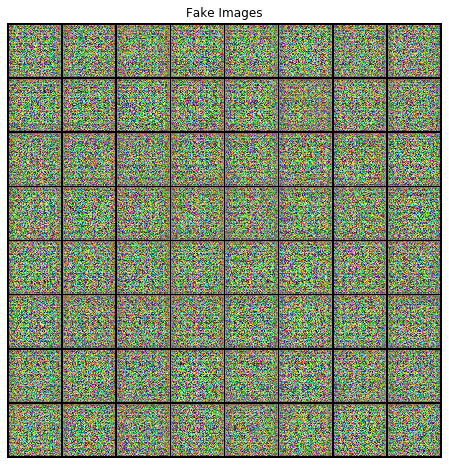

In [14]:
# Plot the fake images from the last epoch
#plt.subplot(1,2,2)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()